In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST, CIFAR10

from IPython.display import clear_output

DEVICE=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

In [2]:
import torch
from pytorch_pretrained_gans import make_gan

# Sample a class-conditional image from BigGAN with default resolution 256
G = make_gan(gan_type='biggan')  # -> nn.Module
y = G.sample_class(batch_size=1)  # -> torch.Size([1, 1000])
z = G.sample_latent(batch_size=1)  # -> torch.Size([1, 128])
x = G(z=z, y=y)  # -> torch.Size([1, 3, 256, 256])

Loading BigGAN model biggan-deep-256 from cache at /home/natifick/.pytorch_pretrained_biggan/e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43


In [3]:
G = G.to(DEVICE)

In [30]:
class SparseAutoEncoder(nn.Module):
    def __init__(self, in_dim, hidden_size, l1 = 0.5, lr=3e-4):
        super().__init__()
        self.E = nn.Linear(in_dim, hidden_size, bias=False)
        self.D = nn.Linear(hidden_size, in_dim, bias=False)
        self.act = nn.ReLU()
        self.l1 = l1
        
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, x):
        hidden = self.act(self.E(x))
        return self.D(hidden)

    def get_loss(self, x_pred, x_true):
        loss = self.loss_fn(x_pred, x_true)
        loss += self.l1 * (torch.norm(self.E.weight, p=1) + torch.norm(self.D.weight, p=1))
        loss.backward()
        self.optimizer.step()
        return loss.item()

In [31]:
def train(SAE_simple, SAE_rec, G, batch_size=8, n_iters=1000):
    losses = {"simple": [], "reconstruction": []}
    ranger = tqdm(range(n_iters))
    for ep in ranger:
        y = G.sample_class(batch_size=batch_size, device=DEVICE)  # -> torch.Size([batch_size, 1000])
        z = G.sample_latent(batch_size=batch_size, device=DEVICE)  # -> torch.Size([batch_size, 128])
        with torch.no_grad():
            x_true = torch.flatten(G(z=z, y=y), start_dim=1) # -> torch.Size([batch_size, 3, 256, 256])
        # Training using reconstruction loss
        z_pred_rec = SAE_rec(z)
        x_pred = torch.flatten(G(z=z_pred_rec), start_dim=1)
        loss_rec = SAE_rec.get_loss(x_pred, x_true)
        losses["reconstruction"].append(loss_rec)
        # Simple training solely on latents
        z_pred_simple = SAE_simple(z)
        loss_simple = SAE_simple.get_loss(z_pred_simple, z)
        losses["simple"].append(loss_simple)
        ranger.set_description_str(f"loss_mse={losses["reconstruction"][-1]}, loss_simple={losses["simple"][-1]}")
    return losses

To measure the effect of the idea we run 2 different autoencoders trained on the same data:
1) Trained on the MSE of output images
2) Trained to simply replicate the input

In [32]:
SAE_simple = SparseAutoEncoder(128, 1280, l1=0.001).to(DEVICE) # x10 extention
SAE_rec = SparseAutoEncoder(128, 1280, l1=0.001).to(DEVICE) # x10 extention

In [33]:
losses = train(SAE_simple, SAE_rec, G, batch_size=8, n_iters=200)

loss_mse=5.32245397567749, loss_simple=4.611482620239258: 100%|██████████| 200/200 [00:26<00:00,  7.47it/s]   


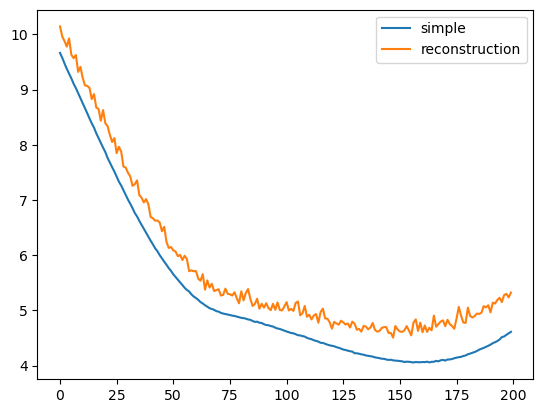

In [34]:
import matplotlib.pyplot as plt

plt.plot(range(len(losses["simple"])), losses["simple"], label="simple")
plt.plot(range(len(losses["reconstruction"])), losses["reconstruction"], label="reconstruction")
plt.legend()
plt.show()